# **Lite-GEffNet** <span style="font-size:60%;">: 제스처 인식을 위한 EfficientNetV2 경량화 버전</span>

In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pickle
import importlib

from utils.data_loader import AugmentedRadarDataset, get_class_weights
from train.train_model import train_model
from utils.plot_save import plot_training_curve, plot_confusion_matrix, save_metrics

2025-07-25 00:54:18.100420: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 00:54:18.128642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-25 00:54:18.521159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# <GPU Memory>
# GPU 설정: 메모리 동적 할당
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU 메모리 할당이 동적으로 설정되었습니다.")
    except RuntimeError as e:
        print(f"GPU 메모리 설정 중 오류 발생: {e}")

GPU 메모리 할당이 동적으로 설정되었습니다.


2025-07-25 00:54:19.734355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 00:54:19.759988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 00:54:19.760465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# 실험 경로 및 데이터셋 설정
experiment_root = "experiments/Step_02"
DATASET_DIR = "dataset/preprocessed"
os.makedirs(experiment_root, exist_ok=True)
label_csv_path = os.path.join(DATASET_DIR, "labels.csv")
split_file_path = os.path.join(experiment_root, "splits.pkl")

n_classes = 15
batch_size = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
apply_class_weights = False

model_list = ["multi_effnet"]

input_shapes = {
    'rtm_input': (224,224,3),
    'dtm_input': (224,224,3)
}

class_names = [
    "hello", 
    "nice to meet you", 
    "thank you", 
    "i respect you", 
    "sign language", 
    "i love you", 
    "take care", 
    "i'm sorry",
    "be happy",
    "no gesture",
    "welcome", 
    "enjoy your meal", 
    "aha, i see",
    "i understand",
    "goodbye"    
]

In [4]:
# === 데이터 준비 ===
df = pd.read_csv(label_csv_path)
df['base_id'] = df['file'].apply(lambda x: x.rsplit('_', 1)[0])
base_df = df.drop_duplicates('base_id')

# label + subject 조합 생성
base_df['subject'] = base_df['base_id'].apply(lambda x: x.split('_')[-1])
base_df['label_subject'] = base_df['label'].astype(str) + "_" + base_df['subject']

# stratify용 map (label+subject)
label_subject_map = dict(zip(base_df['base_id'], base_df['label_subject']))

# 학습용 label map (int)
label_map = dict(zip(base_df['base_id'], base_df['label']))

/tmp/ipykernel_64246/881225751.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['subject'] = base_df['base_id'].apply(lambda x: x.split('_')[-1])
/tmp/ipykernel_64246/881225751.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['label_subject'] = base_df['label'].astype(str) + "_" + base_df['subject']


In [5]:
if not os.path.exists(split_file_path):
    base_ids = base_df['base_id'].tolist()
    stratify_label_subject = [label_subject_map[bid] for bid in base_ids]

    train_base, val_base = train_test_split(
        base_ids, test_size=0.1, stratify=stratify_label_subject, random_state=18)

    split_dict = {'train': train_base, 'val': val_base}
    with open(split_file_path, 'wb') as f:
        pickle.dump(split_dict, f)
    print("[Info] base_id 단위 stratified split (label + subject) -> splits.pkl 저장 완료")
else:
    with open(split_file_path, 'rb') as f:
        split_dict = pickle.load(f)
    train_base, val_base = split_dict['train'], split_dict['val']
    print("[Info] splits.pkl 로드 완료")

[Info] splits.pkl 로드 완료


In [6]:
# 증강
def augment_rtm_dtm(rtm, dtm, max_shift=25, stretch_range=(0.5, 1.5)):

    rtm.set_shape([224, 224, 3])
    dtm.set_shape([224, 224, 3])
    
    # === RTM: 채널 동기화 수직 이동 ===
    shift = tf.random.uniform([], minval=-max_shift, maxval=max_shift + 1, dtype=tf.int32)

    def rtm_shift_fn(img):
        if_shift = tf.cond(
            shift > 0,
            lambda: tf.concat([tf.zeros([shift, 224, 3]), img[:-shift, :, :]], axis=0),
            lambda: tf.concat([img[-shift:, :, :], tf.zeros([-shift, 224, 3])], axis=0),
        )
        return if_shift

    rtm = rtm_shift_fn(rtm)

    # === DTM: 채널 동기화된 위/아래 stretch ===
    scale = tf.random.uniform([], stretch_range[0], stretch_range[1])

    mid = tf.shape(dtm)[0] // 2
    top = dtm[:mid, :, :]
    bottom = dtm[mid:, :, :]

    new_top = tf.image.resize(top, (tf.cast(tf.cast(mid, tf.float32) * scale, tf.int32), 224), method="bilinear")
    new_bottom = tf.image.resize(bottom, (tf.cast(tf.cast(224 - mid, tf.float32) * scale, tf.int32), 224), method="bilinear")

    dtm = tf.concat([new_top, new_bottom], axis=0)
    dtm = tf.image.resize_with_crop_or_pad(dtm, 224, 224)

    return rtm, dtm

2025-07-25 00:54:19.836933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 00:54:19.837133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 00:54:19.837257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 00:54:19.935485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 00:54:19.935643: I tensorflow/compile

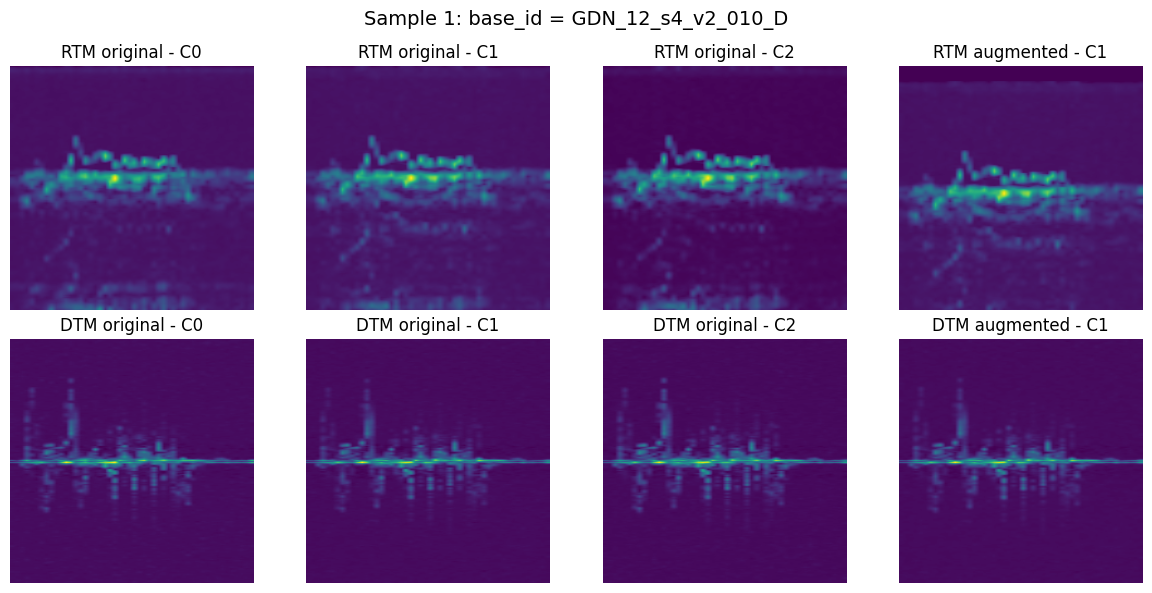

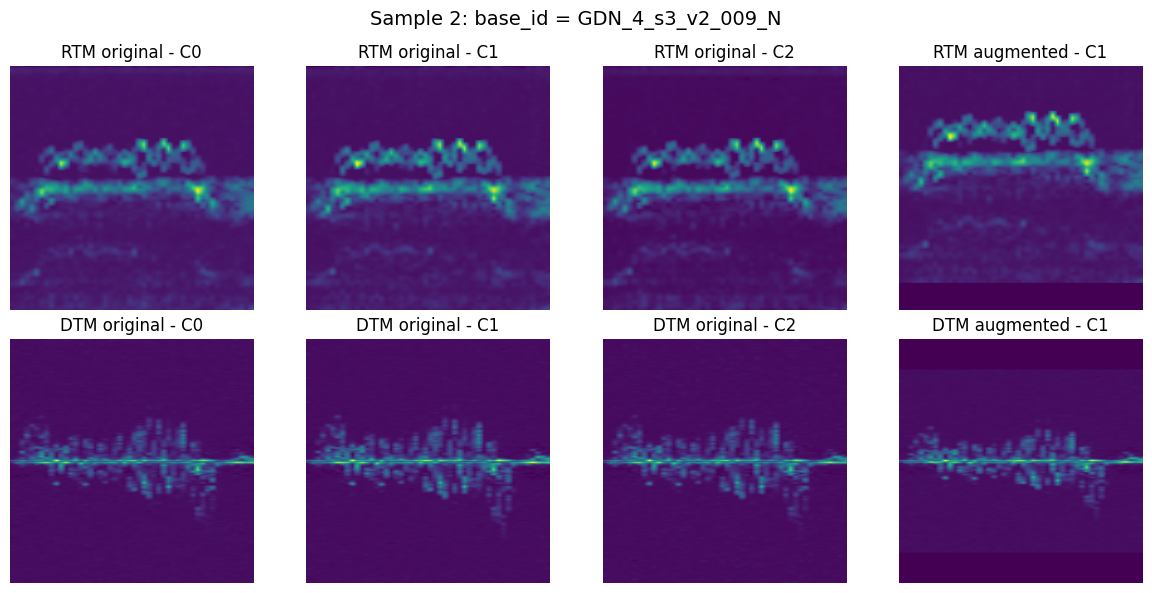

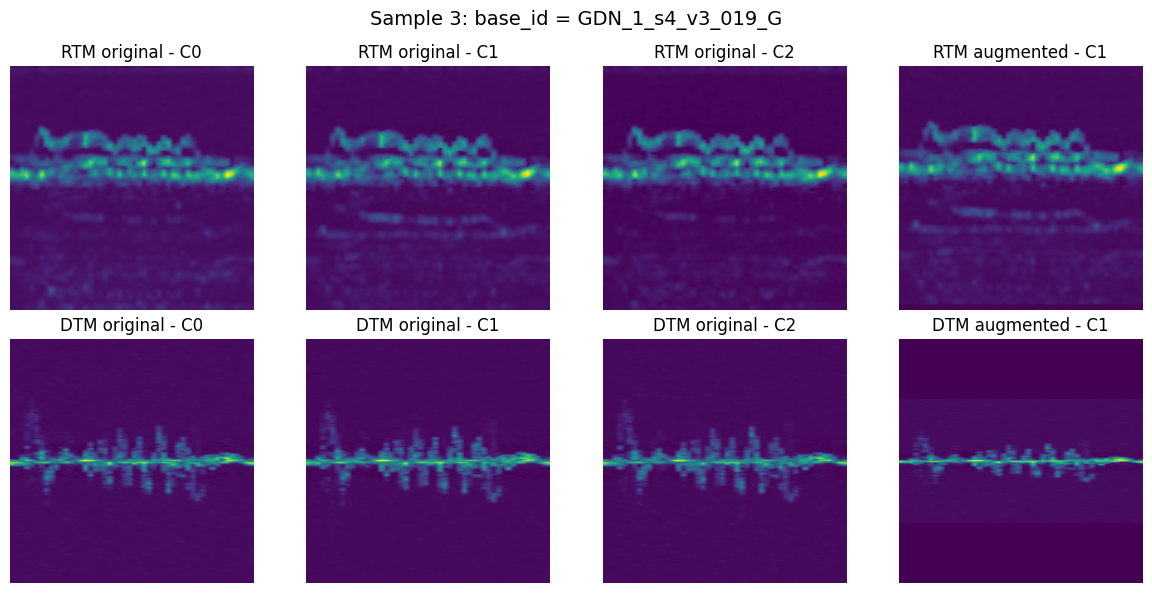

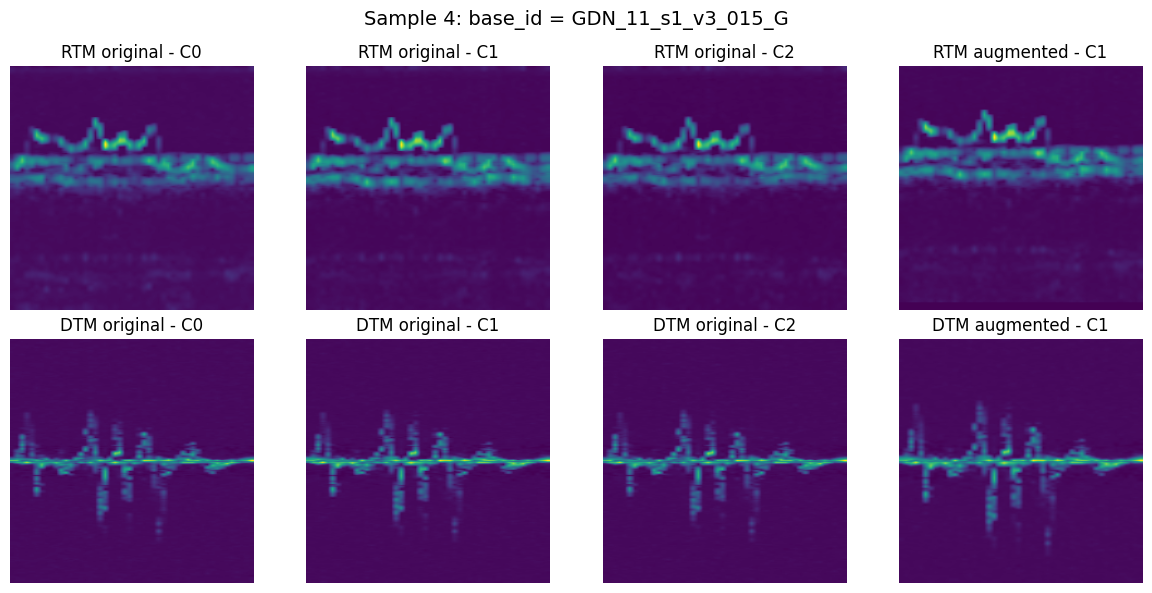

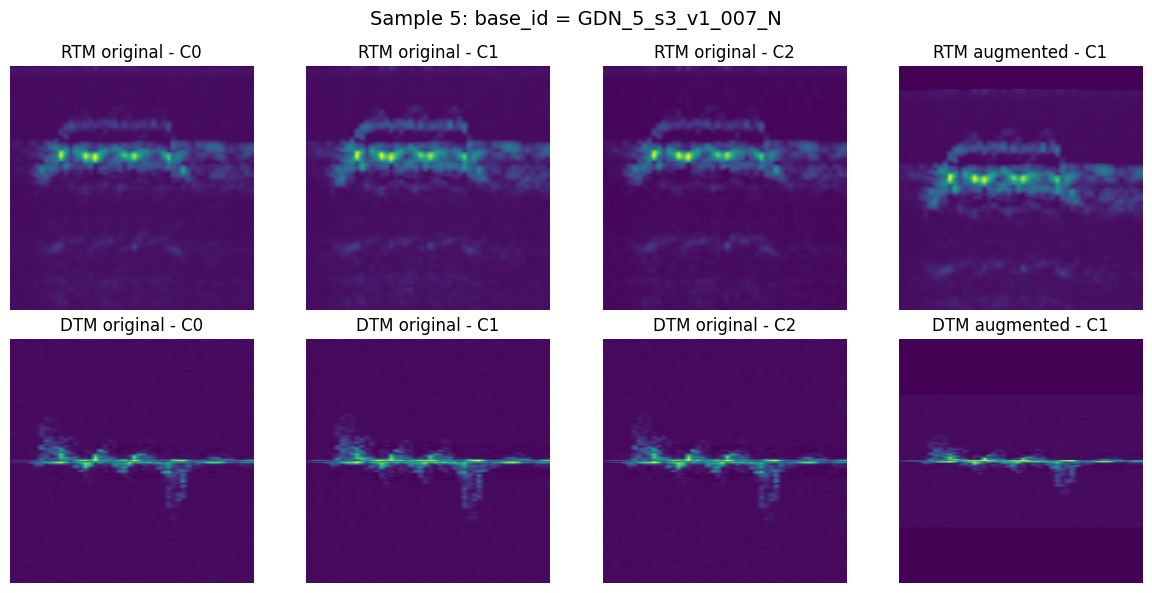

In [7]:
sample_ids = np.random.choice(train_base, size=5, replace=False)

for i, sid in enumerate(sample_ids):
    # 원본 데이터 로딩
    rtm = np.load(os.path.join(DATASET_DIR, f"{sid}_rtm.npy")).astype(np.float32)
    dtm = np.load(os.path.join(DATASET_DIR, f"{sid}_dtm.npy")).astype(np.float32)

    # Tensor로 변환 후 증강 적용
    rtm_tf = tf.convert_to_tensor(rtm)
    dtm_tf = tf.convert_to_tensor(dtm)
    rtm_aug, dtm_aug = augment_rtm_dtm(rtm_tf, dtm_tf)

    # NumPy로 변환
    rtm_aug_np = rtm_aug.numpy()
    dtm_aug_np = dtm_aug.numpy()

    # 시각화
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs[0, 0].imshow(rtm[:, :, 0]); axs[0, 0].set_title("RTM original - C0")
    axs[0, 1].imshow(rtm[:, :, 1]); axs[0, 1].set_title("RTM original - C1")
    axs[0, 2].imshow(rtm[:, :, 2]); axs[0, 2].set_title("RTM original - C2")
    axs[0, 3].imshow(rtm_aug_np[:, :, 1]); axs[0, 3].set_title("RTM augmented - C1")

    axs[1, 0].imshow(dtm[:, :, 0]); axs[1, 0].set_title("DTM original - C0")
    axs[1, 1].imshow(dtm[:, :, 1]); axs[1, 1].set_title("DTM original - C1")
    axs[1, 2].imshow(dtm[:, :, 2]); axs[1, 2].set_title("DTM original - C2")
    axs[1, 3].imshow(dtm_aug_np[:, :, 1]); axs[1, 3].set_title("DTM augmented - C1")

    for ax in axs.flat:
        ax.axis('off')
    plt.suptitle(f"Sample {i+1}: base_id = {sid}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [8]:
# === split summary ===
print(f"\n[Split Info]")
print(f"Train: {len(train_base)} samples")
print(f"Val:   {len(val_base)} samples")

def print_distribution(base_ids, base_df, name=""):
    subset_df = base_df[base_df['base_id'].isin(base_ids)]

    # 라벨 분포
    label_counts = subset_df['label'].value_counts().sort_index()
    label_df = pd.DataFrame({'count': label_counts})
    print(f"\n{name} 라벨 분포:")
    print(label_df)

    # subject 분포
    subject_counts = subset_df['subject'].value_counts()
    subject_df = pd.DataFrame({'count': subject_counts})
    print(f"\n{name} subject 분포:")
    print(subject_df)

    # 라벨 x subject 조합 pivot table
    pivot = pd.crosstab(subset_df['label'], subset_df['subject'])
    print(f"\n{name} 라벨 vs subject 분포:")
    print(pivot)


print_distribution(train_base, base_df, "Train")
print_distribution(val_base, base_df, "Val")


[Split Info]
Train: 4860 samples
Val:   540 samples

Train 라벨 분포:
       count
label       
0        324
1        324
2        324
3        324
4        324
5        324
6        324
7        324
8        324
9        324
10       324
11       324
12       324
13       324
14       324

Train subject 분포:
         count
subject       
D         1620
G         1620
N         1620

Train 라벨 vs subject 분포:
subject    D    G    N
label                 
0        108  108  108
1        108  108  108
2        108  108  108
3        108  108  108
4        108  108  108
5        108  108  108
6        108  108  108
7        108  108  108
8        108  108  108
9        108  108  108
10       108  108  108
11       108  108  108
12       108  108  108
13       108  108  108
14       108  108  108

Val 라벨 분포:
       count
label       
0         36
1         36
2         36
3         36
4         36
5         36
6         36
7         36
8         36
9         36
10        36
11        36
12      

In [9]:
# === split summary ===
print(f"\n[Split Info]")
print(f"Train: {len(train_base)} samples")
print(f"Val:   {len(val_base)} samples")

def print_distribution(base_ids, base_df, name=""):
    subset_df = base_df[base_df['base_id'].isin(base_ids)]

    # 라벨 분포
    label_counts = subset_df['label'].value_counts().sort_index()
    label_df = pd.DataFrame({'count': label_counts})
    print(f"\n{name} 라벨 분포:")
    print(label_df)

    # subject 분포
    subject_counts = subset_df['subject'].value_counts()
    subject_df = pd.DataFrame({'count': subject_counts})
    print(f"\n{name} subject 분포:")
    print(subject_df)

    # 라벨 x subject 조합 pivot table
    pivot = pd.crosstab(subset_df['label'], subset_df['subject'])
    print(f"\n{name} 라벨 vs subject 분포:")
    print(pivot)


print_distribution(train_base, base_df, "Train")
print_distribution(val_base, base_df, "Val")


[Split Info]
Train: 4860 samples
Val:   540 samples

Train 라벨 분포:
       count
label       
0        324
1        324
2        324
3        324
4        324
5        324
6        324
7        324
8        324
9        324
10       324
11       324
12       324
13       324
14       324

Train subject 분포:
         count
subject       
D         1620
G         1620
N         1620

Train 라벨 vs subject 분포:
subject    D    G    N
label                 
0        108  108  108
1        108  108  108
2        108  108  108
3        108  108  108
4        108  108  108
5        108  108  108
6        108  108  108
7        108  108  108
8        108  108  108
9        108  108  108
10       108  108  108
11       108  108  108
12       108  108  108
13       108  108  108
14       108  108  108

Val 라벨 분포:
       count
label       
0         36
1         36
2         36
3         36
4         36
5         36
6         36
7         36
8         36
9         36
10        36
11        36
12      

In [10]:
# === Data Loaders ===
train_data = AugmentedRadarDataset(train_base, label_map, batch_size=batch_size, data_dir=DATASET_DIR, augment_fn=augment_rtm_dtm)
val_data   = AugmentedRadarDataset(val_base, label_map, batch_size=batch_size, data_dir=DATASET_DIR)

train_dataset = train_data.get_dataset()
val_dataset   = val_data.get_dataset()

if apply_class_weights:
    class_weights = get_class_weights(label_map, train_base, n_classes)
else:
    class_weights = None


[실험 시작] multi_effnet

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


2025-07-25 00:54:58.531848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dtm_backbone/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-07-25 00:55:05.165081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-07-25 00:55:05.572626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-25 00:55:05.886585: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f050ac8b4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-25 00:55:05.886614: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-07-25 00:55:05.889241: I tensorflow/compiler/mlir

[CUSTOM CHECKPOINT] Epoch 1: 새로운 최고 정확도 0.2759 - 모델 저장!
304/304 - 99s - loss: 2.5671 - accuracy: 0.1391 - val_loss: 1.9036 - val_accuracy: 0.2759 - lr: 0.0010 - 99s/epoch - 327ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
[CUSTOM CHECKPOINT] Epoch 2: 새로운 최고 정확도 0.7796 - 모델 저장!
304/304 - 28s - loss: 1.6403 - accuracy: 0.4222 - val_loss: 0.7546 - val_accuracy: 0.7796 - lr: 0.0010 - 28s/epoch - 93ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
[CUSTOM CHECKPOINT] Epoch 3: 새로운 최고 정확도 0.8370 - 모델 저장!
304/304 - 29s - loss: 0.9424 - accuracy: 0.6897 - val_loss: 0.4529 - val_accuracy: 0.8370 - lr: 0.0010 - 29s/epoch - 94ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
[CUSTOM CHECKPOINT] Epoch 4: 새로운 최고 정확도 0.9500 - 모델 저장!
304/304 - 29s - loss: 0.5933 - accuracy: 0.8138 - val_loss: 0.1945 - val_accuracy: 0.9500 - lr: 0.0010 - 29s/epoch - 95ms

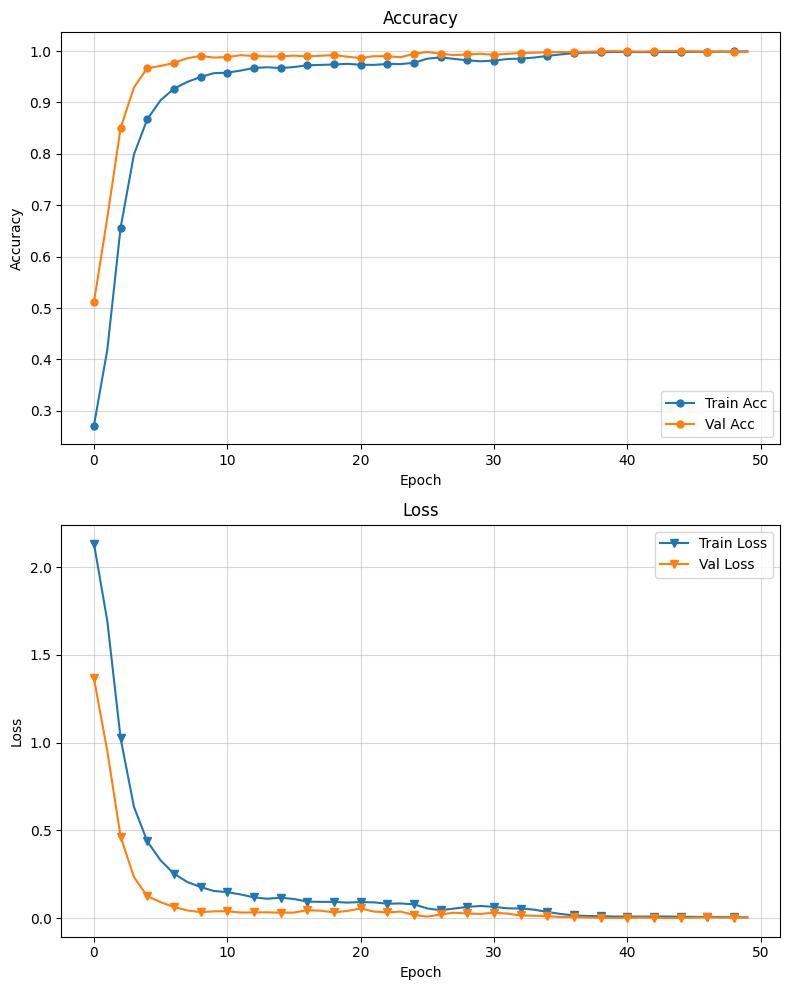

[평가 시작] multi_effnet
34/34 [==============================] - 4s 15ms/step - loss: 1.9843e-04 - accuracy: 1.0000


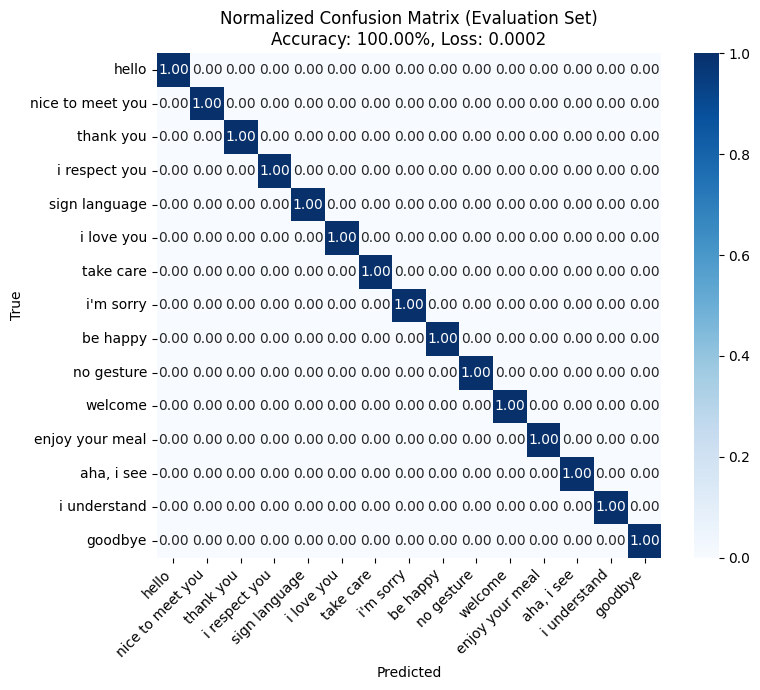

[DONE] multi_effnet: acc=1.0000, loss=0.0002


In [11]:
for model_name in model_list:
    print(f"\n[실험 시작] {model_name}")
    model_dir = os.path.join(experiment_root, model_name)
    os.makedirs(model_dir, exist_ok=True)

    # 동적으로 모델 빌드 함수 import
    module = importlib.import_module(f"model.{model_name}")
    build_fn = getattr(module, f"build_{model_name}")

    # 모델 생성
    model = build_fn(input_shapes=input_shapes, num_classes=n_classes)
    plot_model(model, to_file=os.path.join(model_dir, "architecture.png"), show_shapes=True, expand_nested=False)

    # 학습
    history = train_model(model, train_dataset, val_dataset,
                          output_dir=model_dir,
                          class_weights=class_weights,
                          epochs=EPOCHS,
                          learning_rate=LEARNING_RATE)
    plot_training_curve(history, model_dir, smooth=True)

    # 평가
    print(f"[평가 시작] {model_name}")
    best_model = load_model(os.path.join(model_dir, "best_model.keras"))
    loss, acc = best_model.evaluate(val_dataset, verbose=1)

    # Confusion Matrix
    y_true, y_pred = [], []
    for batch_x, batch_y in val_dataset:
        preds = best_model.predict(batch_x, verbose=0)
        y_true.extend(batch_y.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    save_metrics(acc, loss, model_dir, best_model.count_params(),
                 y_true=y_true, y_pred=y_pred, class_names=class_names)
    plot_confusion_matrix(cm, save_path=model_dir, acc=acc, loss=loss, labels=class_names)

    print(f"[DONE] {model_name}: acc={acc:.4f}, loss={loss:.4f}")